# Multi-Armed Bandits and Reinforcement Learning with Amazon SageMaker

We demonstrate how you can manage your own contextual multi-armed bandit workflow on SageMaker using the built-in [AWS Reinforcement Learning Container](https://github.com/aws/sagemaker-rl-container) container to train and deploy contextual bandit models. We show how to train these models that interact with a live environment (using a simulated client application) and continuously update the model with efficient exploration.

### Why Contextual Bandits?

Wherever we look to personalize content for a user (content layout, ads, search, product recommendations, etc.), contextual bandits come in handy. Traditional personalization methods collect a training dataset, build a model and deploy it for generating recommendations. However, the training algorithm does not inform us on how to collect this dataset, especially in a production system where generating poor recommendations lead to loss of revenue. Contextual bandit algorithms help us collect this data in a strategic manner by trading off between exploiting known information and exploring recommendations which may yield higher benefits. The collected data is used to update the personalization model in an online manner. Therefore, contextual bandits help us train a personalization model while minimizing the impact of poor recommendations.

![](img/multi_armed_bandit_maximize_reward.png)

To implement the exploration-exploitation strategy, we need an iterative training and deployment system that: (1) recommends an action using the contextual bandit model based on user context, (2) captures the implicit feedback over time and (3) continuously trains the model with incremental interaction data. In this notebook, we show how to setup the infrastructure needed for such an iterative learning system. While the example demonstrates a bandits application, these continual learning systems are useful more generally in dynamic scenarios where models need to be continually updated to capture the recent trends in the data (e.g. tracking fraud behaviors based on detection mechanisms or tracking user interests over time). 

In a typical supervised learning setup, the model is trained with a SageMaker training job and it is hosted behind a SageMaker hosting endpoint. The client application calls the endpoint for inference and receives a response. In bandits, the client application also sends the reward (a score assigned to each recommendation generated by the model) back for subsequent model training. These rewards will be part of the dataset for the subsequent model training. 

# Relevant Links

In-Practice
* [AWS Blog Post on Contextual Multi-Armed Bandits](https://aws.amazon.com/blogs/machine-learning/power-contextual-bandits-using-continual-learning-with-amazon-sagemaker-rl/)
* [Multi-Armed Bandits at StitchFix](https://multithreaded.stitchfix.com/blog/2020/08/05/bandits/)
* [Introduction to Contextual Bandits](https://getstream.io/blog/introduction-contextual-bandits/)
* [Vowpal Wabbit Contextual Bandit Algorithms](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-algorithms)

Theory
* [Learning to Interact](https://hunch.net/~jl/interact.pdf)
* [Contextual Bandit Bake-Off](https://arxiv.org/pdf/1802.04064.pdf)
* [Doubly-Robust Policy Evaluation and Learning](https://arxiv.org/pdf/1103.4601.pdf)

Code
* [AWS Open Source Reinforcement Learning Containers](https://github.com/aws/sagemaker-rl-container)
* [AWS Open Source Bandit Experiment Manager](./common/sagemaker_rl/orchestrator/workflow/manager)
* [Vowpal Wabbit Reinforcement Learning Framework](https://github.com/VowpalWabbit/)

# AWS Open Source Bandit `ExperimentManager` Library

![](img/multi_armed_bandit_traffic_shift.png)

The bandit model is implemented by the open source [**Bandit Experiment Manager**](./common/sagemaker_rl/orchestrator/workflow/manager/) provided with this example.  This This implementation continuously updates a Vowpal Wabbit reinforcement learning model using Amazon SageMaker, DynamoDB, Kinesis, and S3.

The client application, a recommender system with a review service in our case, pings the SageMaker hosting endpoint that is serving the bandit model.  The application sends the an `event` with the `context` (ie. user, product, and review text) to the bandit model and receives a recommended action from the bandit model.  In our case, the action is 1 of 2 BERT models that we are testing.  The bandit model stores this event data (given context and recommended action) in S3 using Amazon Kinesis.  _Note:  The context makes this a "contextual bandit" and differentiates this implementation from a regular multi-armed bandit._

The client application uses the recommended BERT model to classify the review text as star rating 1 through 5 and  compares the predicted star rating to the user-selected star rating.  If the BERT model correctly predicts the star rating of the review text (ie. matches the user-selected star rating), then the bandit model is rewarded with `reward=1`.  If the BERT model incorrectly classifies the star rating of the review text, the bandit model is not rewarded (`reward=0`).

The client application stores the rewards data in S3 using Amazon Kinesis.  Periodically (ie. every 100 rewards), we incrementally train an updated bandit model with the latest the reward and event data.  This updated bandit model is evaluated against the current model using a holdout dataset of rewards and events.  If the bandit model accuracy is above a given threshold relative to the existing model, it is automatically deployed in a blue/green manner with no downtime.  SageMaker RL supports offline evaluation by performing counterfactual analysis (CFA).  By default, we apply [**doubly robust (DR) estimation**](https://arxiv.org/pdf/1103.4601.pdf) method. The bandit model tries to minimize the cost (`1 - reward`), so a smaller evaluation score indicates better bandit model performance.

Unlike traditional A/B tests, the bandit model will learn the best BERT model (action) for a given context over time and begin to shift traffic to the best model.  Depending on the aggressiveness of the bandit model algorithm selected, the bandit model will continuously explore the under-performing models, but start to favor and exploit the over-performing models.  And unlike A/B tests, multi-armed bandits allow you to add a new action (ie. BERT model) dynamically throughout the life of the experiment.  When the bandit model sees the new BERT model, it will start sending traffic and exploring the accuracy of the new BERT model - alongside the existing BERT models in the experiment.

#### Local Mode

To facilitate experimentation, we provide a `local_mode` that runs the contextual bandit example using the SageMaker Notebook instance itself instead of the SageMaker training and hosting cluster instances.  The workflow remains the same in `local_mode`, but runs much faster for small datasets.  Hence, it is a useful tool for experimenting and debugging.  However, it will not scale to production use cases with high throughput and large datasets.  In `local_mode`, the training, evaluation, and hosting is done in the local [SageMaker Vowpal Wabbit Docker Container](https://github.com/aws/sagemaker-rl-container).

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [2]:
import yaml
import sys
import numpy as np
import time
import sagemaker

sys.path.append('common')
sys.path.append('common/sagemaker_rl')

### Configuration

The configuration for the bandits application can be specified in a `config.yaml` file as can be seen below. It configures the AWS resources needed. The DynamoDB tables are used to store metadata related to experiments, models and data joins. The `private_resource` specifices the SageMaker instance types and counts used for training, evaluation and hosting. The SageMaker container image is used for the bandits application. This config file also contains algorithm and SageMaker-specific setups.  Note that all the data generated and used for the bandits application will be stored in `s3://sagemaker-{REGION}-{AWS_ACCOUNT_ID}/{experiment_id}/`.

Please make sure that the `num_arms` parameter in the config is equal to the number of actions in the client application (which is defined in the cell below).

The Docker image is defined here:  https://github.com/aws/sagemaker-rl-container/blob/master/vw/docker/8.7.0/Dockerfile

In [3]:
!pygmentize 'config.yaml'

resource:
  shared_resource:
    resources_cf_stack_name: "BanditsSharedResourceStack" # cloud formation stack
    experiment_db:
      table_name: "BanditsExperimentTable" # Dynamo table for status of an experiment
    model_db:
      table_name: "BanditsModelTable" # Dynamo table for status of all models trained
    join_db:
      table_name: "BanditsJoinTable" # Dynamo table for status of all joining job for reward ingestion
    iam_role:
      role_name: "BanditsIAMRole"
  private_resource:
    hosting_fleet:
      instance_type: "ml.t2.medium"
      instance_count: 1
    training_fleet:
      instance_type: "ml.c5.4xlarge"
    evaluation_fleet:
      instance_type: "ml.c5.4xlarge"
image: "462105765813.dkr.ecr.{AWS_REGION}.amazonaws.com/sagemaker-rl-vw-container:vw-8.7.0-cpu" # Vowpal Wabbit container
algor: # Vowpal Wabbit algorithm parameters
  algorithms_parameters:
    exploration_policy: "cover" # supports "egreedy", "bag", "cover"
    epsilon: 0.10 # percent to explore with e

In [4]:
config_file = 'config.yaml'
with open(config_file, 'r') as yaml_file:
    config = yaml.load(yaml_file, Loader=yaml.FullLoader)

# Additional permissions for the IAM role
IAM role requires additional permissions for [AWS CloudFormation](https://aws.amazon.com/cloudformation/), [Amazon DynamoDB](https://aws.amazon.com/dynamodb/), [Amazon Kinesis Data Firehose](https://aws.amazon.com/kinesis/data-firehose/) and [Amazon Athena](https://aws.amazon.com/athena/). Make sure the SageMaker role you are using has the permissions.

In [5]:
# from markdown_helper import *
# from IPython.display import Markdown

# display(Markdown(generate_help_for_experiment_manager_permissions(role)))

### Client Application (Environment)
The client application simulates a live environment that uses the bandit model to recommend a BERT model to classify review text submitted by the application user. 

The logic of reward generation resides in the client application.  We simulate the online learning loop with feedback.  The data consists of 2 actions - 1 for each BERT model under test.  If the bandit model selects the right class, then the model is rewarded with `reward=1`.  Otherwise, the bandit model receives `reward=0`.

The workflow of the client application is as follows:
- Our client application picks sample review text at random, which is sent to the bandit model (SageMaker endpoint) to recommend an action (BERT model) to classify the review text into star rating 1 through 5.
- The bandit model returns an action, an action probability, and an `event_id` for this prediction event.
- Since the client application uses the Amazon Customer Reviews Dataset, we know the true star rating for the review text
- The client application compares the predicted and true star rating and assigns a reward to the bandit model using Amazon Kinesis, S3, and DynamoDB.  (The `event_id` is used to join the event and reward data.)

`event_id` is a unique identifier for each interaction. It is used to join inference data `<state, action, action_probability>` with the reward data. 

In a later cell of this notebook, we illustrate how the client application interacts with the bandit model endpoint and receives the recommended action (BERT model).

### Step-by-step bandits model development

[**Bandit Experiment Manager**](./common/sagemaker_rl/orchestrator/workflow/manager/) is the top level class for all the Bandits/RL and continual learning workflows. Similar to the estimators in the [Sagemaker Python SDK](https://github.com/aws/sagemaker-python-sdk), `ExperimentManager` contains methods for training, deployment and evaluation. It keeps track of the job status and reflects current progress in the workflow.

Start the application using the `ExperimentManager` class 

In [6]:
import time
timestamp = int(time.time())

experiment_name = 'bandits-{}'.format(timestamp)

# `ExperimentManager` will create a AWS CloudFormation Stack of additional resources needed for the Bandit experiment. 

In [7]:
from orchestrator.workflow.manager.experiment_manager import ExperimentManager

bandit_experiment_manager = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Creating a new CloudFormation stack for Shared Resources. You can always reuse this StackName in your other experiments
INFO:orchestrator.resource_manager:[
    {
        "ParameterKey": "IAMRoleName",
        "ParameterValue": "BanditsIAMRole",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ExperimentDbName",
        "ParameterValue": "BanditsExperimentTable",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ExperimentDbRCU",
        "ParameterValue": "5",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ExperimentDbWCU",
        "ParameterValue": "5",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ModelDbName",
        "ParameterValue": "BanditsModelTable",
        "UsePreviousValue": true,
        "ResolvedValue": "strin

In [8]:
try:
    bandit_experiment_manager.clean_resource(experiment_id=bandit_experiment_manager.experiment_id)
    bandit_experiment_manager.clean_table_records(experiment_id=bandit_experiment_manager.experiment_id)
except:
    print('Ignore any errors.  Errors are OK.')

INFO:orchestrator:Deleting hosting endpoint 'bandits-1598134018'...


In [9]:
bandit_experiment_manager = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Using Resources in CloudFormation stack named: BanditsSharedResourceStack for Shared Resources.


# Initialize the Bandit Model
To start a new experiment, we need to initialize the first bandit model or "policy" in reinforcement learning terminology.  

If we have historical data in the format `(state, action, action probability, reward)`, we can perform a "warm start" and learn the bandit model offline.  

However, let's assume we are starting with no historical data and initialize a random bandit model using `initialize_first_model()`.

In [10]:
bandit_experiment_manager.initialize_first_model()

INFO:orchestrator:Next Model name would be bandits-1598134018-model-id-1598134067
INFO:orchestrator:Start training job for model 'bandits-1598134018-model-id-1598134067''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpt2_2pc51_algo-1-phkzn_1 ... 
Attaching to tmpt2_2pc51_algo-1-phkzn_12mdone
algo-1-phkzn_1  | 2020-08-22 22:08:20,861 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-phkzn_1  | 2020-08-22 22:08:20,873 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-phkzn_1  | 2020-08-22 22:08:20,885 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-phkzn_1  | 2020-08-22 22:08:20,894 sagemaker-containers INFO     Invoking user script
algo-1-phkzn_1  | 
algo-1-phkzn_1  | Training Env:
algo-1-phkzn_1  | 
algo-1-phkzn_1  | {
algo-1-phkzn_1  |     "additional_framework_parameters": {
algo-1-phkzn_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-phkzn_1  |     },
algo-1-phkzn_1  |     "channel_input_dirs": {},
algo-1-phkzn_1  |     "current_host": "algo-1-phkzn",
algo-1-phkzn_1  |     "framework_module": null,
algo-1-phkzn_1  |     "hosts": [
algo-1-phkzn_1  |         "algo-1-phkzn"
al

tmpt2_2pc51_algo-1-phkzn_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


# ^^ Ignore `Failed to delete: /tmp/...` message above.  This is OK. ^^

# Check Experiment State:  TRAINED
`training_state`: `TRAINED`

Remember the `last_trained_model_id`.

In [11]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1598134018',
 'training_workflow_metadata': {'last_trained_model_id': 'bandits-1598134018-model-id-1598134067',
  'next_model_to_train_id': None,
  'training_state': <TrainingState.TRAINED: 'TRAINED'>},
 'hosting_workflow_metadata': {'last_hosted_model_id': None,
  'hosting_endpoint': None,
  'hosting_state': None,
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': None,
  'next_join_job_id': None,
  'last_joined_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Deploy the Bandit Model

Once training and evaluation is done, we can deploy the model.

In [12]:
import boto3
account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name

!$(aws ecr get-login --region $region --registry-ids $account_id --no-include-email)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [13]:
# Check the model_id of the last model trained.
print('Deploying newly-trained bandit model: {}'.format(bandit_experiment_manager.last_trained_model_id))

Deploying newly-trained bandit model: bandits-1598134018-model-id-1598134067


In [14]:
print('Deploying bandit model_id {}'.format(bandit_experiment_manager.last_trained_model_id))

bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id) 

Deploying bandit model_id bandits-1598134018-model-id-1598134067


INFO:orchestrator:Model 'bandits-1598134018-model-id-1598134067' is ready to deploy.


Attaching to tmp3enliov9_algo-1-pot79_1
algo-1-pot79_1  | 17:C 22 Aug 2020 22:08:37.361 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
algo-1-pot79_1  | 17:C 22 Aug 2020 22:08:37.361 # Redis version=5.0.6, bits=64, commit=00000000, modified=0, pid=17, just started
algo-1-pot79_1  | 17:C 22 Aug 2020 22:08:37.361 # Configuration loaded
algo-1-pot79_1  | 17:M 22 Aug 2020 22:08:37.361 # You requested maxclients of 10000 requiring at least 10032 max file descriptors.
algo-1-pot79_1  | 17:M 22 Aug 2020 22:08:37.361 # Server can't set maximum open files to 10032 because of OS error: Operation not permitted.
algo-1-pot79_1  | 17:M 22 Aug 2020 22:08:37.361 # Current maximum open files is 4096. maxclients has been reduced to 4064 to compensate for low ulimit. If you need higher maxclients increase 'ulimit -n'.
algo-1-pot79_1  | 17:M 22 Aug 2020 22:08:37.362 # WARNING: The TCP backlog setting of 511 cannot be enforced because /proc/sys/net/core/somaxconn is set to the lower value of 128.
algo-1-

# Check Experiment State
`hosting_state`: `DEPLOYED`

The `last_trained_model_id` and `last_hosted_model_id` are now the same as we just deployed the bandit model.

In [15]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1598134018',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1598134018-model-id-1598134067',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': <HostingState.DEPLOYED: 'DEPLOYED'>,
  'last_hosted_model_id': 'bandits-1598134018-model-id-1598134067',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': None,
  'next_join_job_id': None,
  'last_joined_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Configure the 2 BERT Models to Test with our Bandit Experiment

Now that the last trained bandit model is deployed as a SageMaker Endpoint, the client application will send the context to the endpoint and receive the recommended action.  The bandit model will recommend 1 of 2 actions in our example:  `1` or `2` which correspond to BERT model 1 and BERT model 2, respectively.  Let's configure these 2 BERT models below.

In [16]:
%store -r tensorflow_endpoint_name

In [17]:
model_1_endpoint_name = tensorflow_endpoint_name

In [18]:
print(model_1_endpoint_name)

tensorflow-training-2020-08-22-19-35-37-636-tf-1598132403


In [19]:
client = boto3.client('sagemaker')
waiter = client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=model_1_endpoint_name)

In [20]:
import json
from sagemaker.tensorflow.serving import Predictor

model1 = Predictor(endpoint_name=model_1_endpoint_name,
                   sagemaker_session=sess,
                   content_type='application/json',
                   model_name='saved_model',
                   model_version=0)

In [21]:
reviews = ['This is great!']

model1_predicted_classes = model1.predict(reviews)

for predicted_class, review in zip(model1_predicted_classes, reviews):
    print('[Predicted Star Rating: {}]'.format(predicted_class), review)

[Predicted Star Rating: 5] This is great!


In [22]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">Model 1 SageMaker REST Endpoint</a></b>'.format(region, model_1_endpoint_name)))


In [23]:
%store -r pytorch_endpoint_name

In [24]:
model_2_endpoint_name = pytorch_endpoint_name

In [25]:
print(model_2_endpoint_name)

tensorflow-training-2020-08-22-19-35-37-636-pt-1598133416


In [26]:
waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=model_2_endpoint_name)

In [27]:
import json
from sagemaker.predictor import RealTimePredictor

model2 = RealTimePredictor(endpoint=model_2_endpoint_name,
                           sagemaker_session=sess)

In [28]:
reviews = 'This is great!'

model2_predicted_class = model2.predict(reviews).decode('utf-8')

print(model2_predicted_class)

5


In [29]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">Model 2 SageMaker REST Endpoint</a></b>'.format(region, model_2_endpoint_name)))


# Initialize the Client Application

In [30]:
import csv
import numpy as np

class ClientApp():
    def __init__(self, data, num_events, bandit_model, bert_model_map):
        self.bandit_model = bandit_model
        self.bert_model_map = bert_model_map
        
        self.num_actions = 2

        df_reviews = pd.read_csv(data, 
                                 delimiter='\t', 
                                 quoting=csv.QUOTE_NONE,
                                 compression='gzip')
        df_scrubbed = df_reviews[['review_body', 'star_rating']].sample(n=num_events) # .query('star_rating == 1')
        df_scrubbed = df_scrubbed.reset_index()
        df_scrubbed.shape
        np_reviews = df_scrubbed.to_numpy()

        np_reviews = np.delete(np_reviews, 0, 1)
        
        # Last column is the label, the rest are the features (contexts)
        self.labels = np_reviews[:, -1]
        self.contexts = np_reviews[:, :-1].tolist()

        self.optimal_rewards = [1]
        self.rewards_buffer = []
        self.joined_data_buffer = []

    def choose_random_context(self):
#        context_index = np.random.choice(self.contexts.shape[0])
        context_index = np.random.choice(len(self.contexts))
        context = self.contexts[context_index]
        return context_index, context    

    def clear_buffer(self):
        self.rewards_buffer.clear()
        self.joined_data_buffer.clear()  

    def get_reward(self, 
                   context_index, 
                   action, 
                   event_id, 
                   bandit_model_id, 
                   action_prob, 
                   sample_prob, 
                   local_mode):

        context_to_predict = self.contexts[context_index][0]
#        print('Context to predict{}'.format(context_to_predict))
        print('Context index {}'.format(context_index))
    
        label = self.labels[context_index]
        print('Label {}'.format(label))
        
        print('Action {}'.format(action))
        
        bert_model = self.bert_model_map[action]
        try: 
            # TensorFlow takes a list and returns str
            bert_predicted_class = bert_model.predict([context_to_predict])[0]
            bert_predicted_class #.decode('utf-8')
            print('Predicted Class from Model 1 {}'.format(bert_predicted_class))        
        except:
            # PyTorch takes a single review and returns bytes
            #context = context_index            
            bert_predicted_class = bert_model.predict(context_to_predict)[0]
            bert_predicted_class = bert_predicted_class #.decode('utf-8')
            print('Predicted Class from Model 2 {}'.format(bert_predicted_class))
        
        # Calculate difference between predicted and actual label
        if abs(int(bert_predicted_class) - int(label)) <= 1:
            reward = 1
        else:
            reward = 0

        if local_mode:
            json_blob = {"reward": reward,
                         "event_id": event_id,
                         "action": action,
                         "action_prob": action_prob,
                         "model_id": bandit_model_id,
                         "observation": [context_index],
                         "sample_prob": sample_prob}
            
            self.joined_data_buffer.append(json_blob)
        else:
            json_blob = {"reward": reward, "event_id": event_id}
            self.rewards_buffer.append(json_blob)
        
        return reward
    

In [31]:
bandit_model = bandit_experiment_manager.predictor

client_app = ClientApp(data='./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz',
                       num_events=100,
                       bandit_model=bandit_model,
                       bert_model_map={
                         1: model1,
                         2: model2
                       })

Make sure that `num_arms` specified in `config.yaml` is equal to the total unique actions in the simulation application.

In [32]:
print('Testing {} BERT models'.format(client_app.num_actions))

assert client_app.num_actions == bandit_experiment_manager.config["algor"]["algorithms_parameters"]["num_arms"]

Testing 2 BERT models


In [33]:
import time

context_index, context = client_app.choose_random_context()
action, event_id, bandit_model_id, action_prob, sample_prob = bandit_model.get_action(obs=[context_index])

print('event ID: {}\nbert_model_id: {}\naction_probability: {}'.format(event_id, action, action_prob, bandit_model_id))

event ID: 17680889258852755737823788369519443970
bert_model_id: 1
action_probability: 1.0


# Generate Sample Events to Test the Bandit `ExperimentManager`
Thsi will generated sample contexts to pass as events to the bandit using the Amazon Customer Reviews Dataset.  The bandit model will recommend an action (BERT model) based on the context and current state of the bandit.  We will assign a reward using the star ratings from Amazon Customer Reviews Dataset.

Client application generates a reward after receiving the recommended action and stores the tuple `<eventID, reward>` in S3. In this case, reward is 1 if predicted action is the true class, and 0 otherwise. SageMaker hosting endpoint saves all the inferences `<eventID, state, action, action probability>` to S3 using [**Kinesis Firehose**](https://aws.amazon.com/kinesis/data-firehose/). The `ExperimentManager` joins the reward with state, action and action probability using [**Amazon Athena**](https://aws.amazon.com/athena/). 

In [34]:
local_mode = bandit_experiment_manager.local_mode

num_events = 100 

print('Generating {} sample events...'.format(num_events))

for i in range(num_events):
    context_index, context = client_app.choose_random_context()
#    print('Context to predict = {}'.format(context))
#    print('Context observation = [{}]'.format(context_index))    
    action, event_id, bandit_model_id, action_prob, sample_prob = bandit_model.get_action(obs=[context_index])

    reward = client_app.get_reward(context_index=context_index, 
                                   action=action, 
                                   event_id=event_id, 
                                   bandit_model_id=bandit_model_id, 
                                   action_prob=action_prob, 
                                   sample_prob=sample_prob, 
                                   local_mode=local_mode)    

Generating 100 sample events...
Context index 97
Label 4
Action 1
Predicted Class from Model 1 2
Context index 78
Label 5
Action 1
Predicted Class from Model 1 1
Context index 56
Label 4
Action 1
Predicted Class from Model 1 2
Context index 87
Label 1
Action 1
Predicted Class from Model 1 1
Context index 61
Label 5
Action 1
Predicted Class from Model 1 2
Context index 19
Label 4
Action 1
Predicted Class from Model 1 1
Context index 91
Label 5
Action 1
Predicted Class from Model 1 2
Context index 9
Label 4
Action 1
Predicted Class from Model 1 2
Context index 54
Label 4
Action 1
Predicted Class from Model 1 2
Context index 61
Label 5
Action 1
Predicted Class from Model 1 2
Context index 26
Label 5
Action 1
Predicted Class from Model 1 2
Context index 63
Label 5
Action 1
Predicted Class from Model 1 2
Context index 17
Label 4
Action 1
Predicted Class from Model 1 1
Context index 22
Label 4
Action 1
Predicted Class from Model 1 2
Context index 48
Label 1
Action 1
Predicted Class from Mode

# Create Bandit Model Training Data

Join `Event` and `Reward` data and upload to S3 in the following format:

```
{
 'reward': -1, # -1 if the model is wrong, +1 if the model is correct
 'event_id': 131181492351609994318271340276526219266, # unique event id
 'action': 1, # suggested action (bert_model_id 1 or 2)
 'action_prob': 0.9995, # probability that the suggested action is correct
 'model_id': 'bandits-1597631299-model-id-1597631304', # unique bandit_model_id
 'observation': [54], # feature (review_id)
 'sample_prob': 0.43410828171830174 
}
```


In [35]:
if local_mode:
    print('Using local mode with memory buffers.')
    print()
    print(client_app.joined_data_buffer)
    bandit_experiment_manager.ingest_joined_data(client_app.joined_data_buffer)
else:
    print("Using production mode with Kinesis Firehose.  Waiting to flush to S3...")
    print()
    time.sleep(60) # Wait for firehose to flush data to S3
    rewards_s3_prefix = bandit_experiment_manager.ingest_rewards(client_app.rewards_buffer)
    bandit_experiment_manager.join(rewards_s3_prefix)

Using local mode with memory buffers.

[{'reward': 0, 'event_id': 17686743427780934729728575332009771010, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1598134018-model-id-1598134067', 'observation': [97], 'sample_prob': 0.7781926705158639}, {'reward': 0, 'event_id': 17815322020443709181218220869585862658, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1598134018-model-id-1598134067', 'observation': [78], 'sample_prob': 0.002630104906929276}, {'reward': 0, 'event_id': 17921589962542466794578369385617031170, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1598134018-model-id-1598134067', 'observation': [56], 'sample_prob': 0.39878469769110403}, {'reward': 1, 'event_id': 18056542460879513811385652587097358338, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandits-1598134018-model-id-1598134067', 'observation': [87], 'sample_prob': 0.6672559594499614}, {'reward': 0, 'event_id': 18154022415192189224430621257272262658, 'action': 1, 'action_prob': 1.0, 'model_id': 'bandi

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.8
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134144
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134144/train/local-joined-data-1598134145.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134144/eval/local-joined-data-1598134145.csv


# Check Experiment Status:  Joined
`joining_state`:  `SUCCEEDED`

In [36]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1598134018',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1598134018-model-id-1598134067',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': 'DEPLOYED',
  'last_hosted_model_id': 'bandits-1598134018-model-id-1598134067',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-1598134018-join-job-id-1598134144',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

# Review Bandit Model Training Data

In [37]:
print('Bandit model training data {}'.format(bandit_experiment_manager.last_joined_job_train_data))

Bandit model training data s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134144/train


In [38]:
from sagemaker.s3 import S3Downloader

bandit_model_train_data_s3_uri = S3Downloader.list(bandit_experiment_manager.last_joined_job_train_data)[0]
print(bandit_model_train_data_s3_uri)

s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134144/train/local-joined-data-1598134145.csv


In [39]:
from sagemaker.s3 import S3Downloader

bandit_model_train_data = S3Downloader.read_file(bandit_model_train_data_s3_uri)
print(bandit_model_train_data)

"reward","event_id","action","action_prob","model_id","observation","sample_prob"
"0","17686743427780934729728575332009771010","1","1.0","bandits-1598134018-model-id-1598134067","[97]","0.7781926705158639"
"0","17815322020443709181218220869585862658","1","1.0","bandits-1598134018-model-id-1598134067","[78]","0.002630104906929276"
"0","17921589962542466794578369385617031170","1","1.0","bandits-1598134018-model-id-1598134067","[56]","0.39878469769110403"
"1","18056542460879513811385652587097358338","1","1.0","bandits-1598134018-model-id-1598134067","[87]","0.6672559594499614"
"0","18154022415192189224430621257272262658","1","1.0","bandits-1598134018-model-id-1598134067","[61]","0.4644965283011777"
"0","18398222626820155336324250113640890370","1","1.0","bandits-1598134018-model-id-1598134067","[19]","0.5662620809532043"
"0","18504601488346432919767725640317534210","1","1.0","bandits-1598134018-model-id-1598134067","[91]","0.544420967281935"
"0","18760911724614704335683919787725029378","1"

# Train the Bandit Model

Now we can train a new model with newly collected experiences, and host the resulting model.

In [40]:
print('Trained bandit model id {}'.format(bandit_experiment_manager.last_trained_model_id))

bandit_experiment_manager.train_next_model(input_data_s3_prefix=bandit_experiment_manager.last_joined_job_train_data)

Trained bandit model id bandits-1598134018-model-id-1598134067


INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134067 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134153''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpw1g4xmso_algo-1-tiqts_1 ... 
Attaching to tmpw1g4xmso_algo-1-tiqts_12mdone
algo-1-tiqts_1  | 2020-08-22 22:09:18,297 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-tiqts_1  | 2020-08-22 22:09:18,309 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-tiqts_1  | 2020-08-22 22:09:18,320 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-tiqts_1  | 2020-08-22 22:09:18,329 sagemaker-containers INFO     Invoking user script
algo-1-tiqts_1  | 
algo-1-tiqts_1  | Training Env:
algo-1-tiqts_1  | 
algo-1-tiqts_1  | {
algo-1-tiqts_1  |     "additional_framework_parameters": {
algo-1-tiqts_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-tiqts_1  |     },
algo-1-tiqts_1  |     "channel_input_dirs": {
algo-1-tiqts_1  |         "training": "/opt/ml/input/data/training",
algo-1-tiqts_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-tiqts_1  |     },
al

tmpw1g4xmso_algo-1-tiqts_1 exited with code 0
Aborting on container exit...


===== Job Complete =====


# Ignore ^^ `Failed to delete` Error Above ^^ 

# Deploy the Bandit Model

In [41]:
print('Deploying bandit model id {}'.format(bandit_experiment_manager.last_hosted_model_id))

bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)

Deploying bandit model id bandits-1598134018-model-id-1598134067


INFO:orchestrator:Model 'bandits-1598134018-model-id-1598134153' is ready to deploy.


algo-1-pot79_1  | [08/22/2020 22:09:29 INFO 140475102906112] Found new model! Trying to replace Model ID: bandits-1598134018-model-id-1598134067 with Model ID: bandits-1598134018-model-id-1598134153
algo-1-pot79_1  | [2020-08-22 22:09:29 +0000] [23] [INFO] Handling signal: hup
algo-1-pot79_1  | [2020-08-22 22:09:29 +0000] [23] [INFO] Hang up: Master
algo-1-pot79_1  | [2020-08-22 22:09:29 +0000] [38] [INFO] Booting worker with pid: 38
algo-1-pot79_1  | [2020-08-22 22:09:29 +0000] [39] [INFO] Booting worker with pid: 39
algo-1-pot79_1  | [08/22/2020 22:09:29 INFO 140475102906112] creating an instance of VWModel
algo-1-pot79_1  | [08/22/2020 22:09:29 INFO 140475102906112] successfully created VWModel
algo-1-pot79_1  | [08/22/2020 22:09:29 INFO 140475102906112] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/rTV9ZGn7/vw.model']
algo-1-pot79_1  | [08/22/2020 22:09:29 INFO 140475102906112] Loaded weights successfully

# Continuously Train, Evaluate, and Deploy a New Bandit Model

#### Train a New Bandit Model
The above cells explained the individual steps in the training workflow. To train a model to convergence, we will continually train the model based on data collected with client application interactions. We demonstrate the continual training loop in a single cell below.

#### Evaluate New Bandit Model Against Current Bandit Model Before Deploying
After every training cycle, we evaluate if the newly trained model (`last_trained_model_id`) would perform better than the one currently deployed (`last_hosted_model_id`) using a holdout evaluation dataset.  

Details of the join, train, and evaluation steps are tracked in the `BanditsJoinTable` and `BanditsModelTable` DynamoDB tables.  When you have multiple experiments, you can compare them in the `BanditsExperimentTable` DynamoDB table.

#### Deploy the New Bandit Model
If the new bandit model is better than the current bandit model (based on offline evaluation), then we will automatically deploy the new bandit model using a blue-green deployment to avoid downtime. 

#### Monitor the Bandit Model in CloudWatch

In [42]:
from markdown_helper import *
from IPython.display import Markdown

display(Markdown(bandit_experiment_manager.get_cloudwatch_dashboard_details()))

You can monitor your Training/Hosting evaluation metrics on this [CloudWatch Dashboard](https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#dashboards:name=bandits-1598134018;start=PT1H)

(Note: This would need Trained/Hosted Models to be evaluated in order to publish Evaluation Scores)

In [43]:
start_time = time.time()
do_evaluation = True
total_loops = 10 # Increase for higher accuracy
retrain_batch_size = 100 # Model will be trained after every `batch_size` number of data instances
rewards_list = []
event_list = []

local_mode = bandit_experiment_manager.local_mode
for loop_no in range(total_loops):
    print(f"""
    #############
    #### Loop {loop_no+1}
    #############
    """)
    
    # Generate experiences and log them
    for i in range(retrain_batch_size):
        context_index, context = client_app.choose_random_context()
        action, event_id, bandit_model_id, action_prob, sample_prob = bandit_model.get_action(obs=[context_index])

        print('*** Event ID {} ***'.format(event_id))
        print('Context {}'.format(context_index))    
        print('Recommended Action (BERT model) {}'.format(action))
        print('Action Success Probability {}'.format(action_prob))
        print('Action Sample Probability {}'.format(sample_prob))

        reward = client_app.get_reward(context_index=context_index, 
                                       action=action, 
                                       event_id=event_id, 
                                       bandit_model_id=bandit_model_id, 
                                       action_prob=action_prob, 
                                       sample_prob=sample_prob, 
                                       local_mode=local_mode)

        rewards_list.append(reward)  
        
    # Publish rewards sum for this batch to CloudWatch for monitoring 
    bandit_experiment_manager.cw_logger.publish_rewards_for_simulation(
        bandit_experiment_manager.experiment_id,
        sum(rewards_list[-retrain_batch_size:])/retrain_batch_size
    )
    
    # Join the events and rewards data to use for the next bandit-model training job
    # Use 90% as the training dataset and 10% as the the holdout evaluation dataset
    if local_mode:        
        bandit_experiment_manager.ingest_joined_data(client_app.joined_data_buffer,
                                                     ratio=0.90)
    else:
        # Kinesis Firehose => S3 => Athena
        print("Waiting for firehose to flush data to s3...")
        time.sleep(60) 
        rewards_s3_prefix = bandit_experiment_manager.ingest_rewards(client_app.rewards_buffer)
        bandit_experiment_manager.join(rewards_s3_prefix, ratio=0.90)
    
    # Train 
    bandit_experiment_manager.train_next_model(
        input_data_s3_prefix=bandit_experiment_manager.last_joined_job_train_data)

    # Evaluate and/or deploy the new bandit model
    if do_evaluation:
        bandit_experiment_manager.evaluate_model(
            input_data_s3_prefix=bandit_experiment_manager.last_joined_job_eval_data,
            evaluate_model_id=bandit_experiment_manager.last_trained_model_id)

        eval_score_last_trained_model = bandit_experiment_manager.get_eval_score(
            evaluate_model_id=bandit_experiment_manager.last_trained_model_id,
            eval_data_path=bandit_experiment_manager.last_joined_job_eval_data)

        bandit_experiment_manager.evaluate_model(
            input_data_s3_prefix=bandit_experiment_manager.last_joined_job_eval_data,
            evaluate_model_id=bandit_experiment_manager.last_hosted_model_id)

        eval_score_last_hosted_model = bandit_experiment_manager.get_eval_score(
            evaluate_model_id=bandit_experiment_manager.last_hosted_model_id, 
            eval_data_path=bandit_experiment_manager.last_joined_job_eval_data)
    
        print('New bandit model evaluation score {}'.format(eval_score_last_hosted_model))
        print('Current bandit model evaluation score {}'.format(eval_score_last_trained_model))

        if eval_score_last_trained_model <= eval_score_last_hosted_model:
            print('Deploying new bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
            bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)
        else:
            print('Not deploying bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
    else:
        # Just deploy the new bandit model without evaluating against previous model
        print('Deploying new bandit model id {} in loop {}'.format(bandit_experiment_manager.last_trained_model_id, loop_no))
        bandit_experiment_manager.deploy_model(model_id=bandit_experiment_manager.last_trained_model_id)
    
    client_app.clear_buffer()
    
print(f"Total time taken to complete {total_loops} loops: {time.time() - start_time}")


    #############
    #### Loop 1
    #############
    
*** Event ID 55162570667207129598102266368163446786 ***
Context 93
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.5568404405044832
Context index 93
Label 5
Action 2
Predicted Class from Model 2 50
*** Event ID 55247350347068768435887968178865831938 ***
Context 40
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.7273007061521397
Context index 40
Label 5
Action 2
Predicted Class from Model 2 50
*** Event ID 55327564107924710223784197580177670146 ***
Context 42
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.1626378577342512
Context index 42
Label 4
Action 2
Predicted Class from Model 2 50
*** Event ID 55410315546825983896470526429985112066 ***
Context 85
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.5149160126862962
Context index 85
Label 5
Action 2
Pr

Predicted Class from Model 2 50
*** Event ID 58032499934858835257355765007554576386 ***
Context 67
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.40197513340839053
Context index 67
Label 1
Action 2
Predicted Class from Model 2 50
*** Event ID 58109535061834704758084719661345275906 ***
Context 68
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.06951366128757197
Context index 68
Label 3
Action 2
Predicted Class from Model 2 50
*** Event ID 58197708083896829539392574723674210306 ***
Context 88
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.7506189290752352
Context index 88
Label 2
Action 2
Predicted Class from Model 2 50
*** Event ID 58280129141360418729791138495208751106 ***
Context 38
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.9837497087078112
Context index 38
Label 4
Action 2
Predicted Class from Model

Predicted Class from Model 2 50
*** Event ID 60960969307229080548309421621494546434 ***
Context 14
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.6553145612290204
Context index 14
Label 5
Action 2
Predicted Class from Model 2 50
*** Event ID 61042722471282674490342071817527754754 ***
Context 5
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.9455635481129947
Context index 5
Label 1
Action 2
Predicted Class from Model 2 50
*** Event ID 61136962786030141634740778490815184898 ***
Context 34
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.8000986987149571
Context index 34
Label 5
Action 2
Predicted Class from Model 2 50
*** Event ID 61216067352610883719967676512588660738 ***
Context 95
Recommended Action (BERT model) 2
Action Success Probability 1.0
Action Sample Probability 0.19345077526159082
Context index 95
Label 5
Action 2
Predicted Class from Model 2 

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134185
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134185/train/local-joined-data-1598134186.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134185/eval/local-joined-data-1598134186.csv
INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134153 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134194''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpm1w8z9yb_algo-1-j50hp_1 ... 
Attaching to tmpm1w8z9yb_algo-1-j50hp_12mdone
algo-1-j50hp_1  | 2020-08-22 22:09:59,154 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-j50hp_1  | 2020-08-22 22:09:59,166 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-j50hp_1  | 2020-08-22 22:09:59,177 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-j50hp_1  | 2020-08-22 22:09:59,186 sagemaker-containers INFO     Invoking user script
algo-1-j50hp_1  | 
algo-1-j50hp_1  | Training Env:
algo-1-j50hp_1  | 
algo-1-j50hp_1  | {
algo-1-j50hp_1  |     "additional_framework_parameters": {
algo-1-j50hp_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-j50hp_1  |     },
algo-1-j50hp_1  |     "channel_input_dirs": {
algo-1-j50hp_1  |         "training": "/opt/ml/input/data/training",
algo-1-j50hp_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-j50hp_1  |     },
al

tmpm1w8z9yb_algo-1-j50hp_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134194' with evaluation job id 'bandits-1598134018-model-id-1598134194-eval-1598134209'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134194' on eval data set 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134185/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598134018-model-id-1598134194'with data 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134185/eval' is 0.281687.
INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134153' with evaluation job id 'bandits-1598134018-model-id-1598134153-eval-1598134224'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134153' on eval data set 

New bandit model evaluation score 0.5625
Current bandit model evaluation score 0.281687
Deploying new bandit model id bandits-1598134018-model-id-1598134194 in loop 0


INFO:orchestrator:Model 'bandits-1598134018-model-id-1598134194' is ready to deploy.


algo-1-pot79_1  | [08/22/2020 22:10:40 INFO 140475102906112] Found new model! Trying to replace Model ID: bandits-1598134018-model-id-1598134153 with Model ID: bandits-1598134018-model-id-1598134194
algo-1-pot79_1  | [2020-08-22 22:10:40 +0000] [23] [INFO] Handling signal: hup
algo-1-pot79_1  | [2020-08-22 22:10:40 +0000] [23] [INFO] Hang up: Master
algo-1-pot79_1  | [2020-08-22 22:10:40 +0000] [52] [INFO] Booting worker with pid: 52
algo-1-pot79_1  | [2020-08-22 22:10:40 +0000] [53] [INFO] Booting worker with pid: 53
algo-1-pot79_1  | [08/22/2020 22:10:40 INFO 140475102906112] creating an instance of VWModel
algo-1-pot79_1  | [08/22/2020 22:10:40 INFO 140475102906112] successfully created VWModel
algo-1-pot79_1  | [08/22/2020 22:10:40 INFO 140475102906112] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/bRTRxDnf/vw.model']
algo-1-pot79_1  | [08/22/2020 22:10:40 INFO 140475102906112] Loaded weights successfully

Predicted Class from Model 1 2
*** Event ID 113970102125497411201152601405560848386 ***
Context 2
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.2913188290759797
Context index 2
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 114071929329087244298445800878610972674 ***
Context 88
Recommended Action (BERT model) 1
Action Success Probability 0.5
Action Sample Probability 0.35231778610647824
Context index 88
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 114208700113753993681366821499663679490 ***
Context 34
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.08001970467431052
Context index 34
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 114317158714546270703672127555036643330 ***
Context 92
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.3672509519883679
Context index 92
Label 5
Action 1
Predicted Class from Mo

Predicted Class from Model 1 2
*** Event ID 118660191468894945762716945325097091074 ***
Context 80
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.04676891083719881
Context index 80
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 118764538128052732465901146449447616514 ***
Context 55
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.16113511196614638
Context index 55
Label 1
Action 2
Predicted Class from Model 2 50
*** Event ID 118854860610163869238687914359149166594 ***
Context 1
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9511764853389807
Context index 1
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 118964919619838934400612610002318917634 ***
Context 41
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.3236140569570466
Context index 41
Label 4
Action 1
Predicted Cl

Predicted Class from Model 1 2
*** Event ID 122829930047939420718096366659305603074 ***
Context 96
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.2896297239366906
Context index 96
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 122937019586083451249693131969708294146 ***
Context 98
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.6722325275482938
Context index 98
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 123067118567184874432789873301023490050 ***
Context 61
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.7738596917892273
Context index 61
Label 5
Action 2
Predicted Class from Model 2 50
*** Event ID 123179277123166567600084136223849971714 ***
Context 65
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.017939406509019262
Context index 65
Label 1
Action 2
Predi

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134262
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134262/train/local-joined-data-1598134262.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134262/eval/local-joined-data-1598134263.csv
INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134194 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134271''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpdjpkf7ud_algo-1-9vtr3_1 ... 
Attaching to tmpdjpkf7ud_algo-1-9vtr3_12mdone
algo-1-9vtr3_1  | 2020-08-22 22:11:16,114 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-9vtr3_1  | 2020-08-22 22:11:16,126 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-9vtr3_1  | 2020-08-22 22:11:16,137 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-9vtr3_1  | 2020-08-22 22:11:16,147 sagemaker-containers INFO     Invoking user script
algo-1-9vtr3_1  | 
algo-1-9vtr3_1  | Training Env:
algo-1-9vtr3_1  | 
algo-1-9vtr3_1  | {
algo-1-9vtr3_1  |     "additional_framework_parameters": {
algo-1-9vtr3_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-9vtr3_1  |     },
algo-1-9vtr3_1  |     "channel_input_dirs": {
algo-1-9vtr3_1  |         "training": "/opt/ml/input/data/training",
algo-1-9vtr3_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-9vtr3_1  |     },
al

tmpdjpkf7ud_algo-1-9vtr3_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134271' with evaluation job id 'bandits-1598134018-model-id-1598134271-eval-1598134286'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134271' on eval data set 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134262/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598134018-model-id-1598134271'with data 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134262/eval' is 0.890567.
INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134194' with evaluation job id 'bandits-1598134018-model-id-1598134194-eval-1598134302'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134194' on eval data set 

New bandit model evaluation score 0.676281
Current bandit model evaluation score 0.890567
Not deploying bandit model id bandits-1598134018-model-id-1598134271 in loop 1

    #############
    #### Loop 3
    #############
    
*** Event ID 165608880876470271592840747465105866754 ***
Context 15
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7863490804016539
Context index 15
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 165741136448155333051585650381401751554 ***
Context 2
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9821864748859521
Context index 2
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 165860475452505693995372677827474358274 ***
Context 62
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.3594875483719263
Context index 62
Label 5
Action 1
Predicted Class from Model 1 5
*** Event ID 1659860861582006841037002718

Predicted Class from Model 1 2
*** Event ID 169547420585355371214114944456080883714 ***
Context 60
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.2690088119831199
Context index 60
Label 5
Action 1
Predicted Class from Model 1 4
*** Event ID 169646836875959895247147360975429173250 ***
Context 8
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.17621296994237168
Context index 8
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 169756011699341301222398302292274184194 ***
Context 88
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.022049619559745826
Context index 88
Label 2
Action 2
Predicted Class from Model 2 50
*** Event ID 169844072217412655745391850216685174786 ***
Context 14
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7659855060316695
Context index 14
Label 5
Action 1
Predicted Class 

Predicted Class from Model 2 53
*** Event ID 173401953881244971218505782120263319554 ***
Context 58
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.09560234463103279
Context index 58
Label 1
Action 2
Predicted Class from Model 2 50
*** Event ID 173479034168273473846573375469944700930 ***
Context 7
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5671941260734078
Context index 7
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 173610425360705504684728922445903429634 ***
Context 17
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8542279125249199
Context index 17
Label 4
Action 1
Predicted Class from Model 1 1
*** Event ID 173723803238108292376421622020991746050 ***
Context 63
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.2881808564687952
Context index 63
Label 5
Action 2
Predicted Class f

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134328
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134328/train/local-joined-data-1598134329.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134328/eval/local-joined-data-1598134329.csv
INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134271 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134337''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmppqyonpxj_algo-1-aiktm_1 ... 
Attaching to tmppqyonpxj_algo-1-aiktm_12mdone
algo-1-aiktm_1  | 2020-08-22 22:12:22,334 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-aiktm_1  | 2020-08-22 22:12:22,346 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-aiktm_1  | 2020-08-22 22:12:22,357 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-aiktm_1  | 2020-08-22 22:12:22,366 sagemaker-containers INFO     Invoking user script
algo-1-aiktm_1  | 
algo-1-aiktm_1  | Training Env:
algo-1-aiktm_1  | 
algo-1-aiktm_1  | {
algo-1-aiktm_1  |     "additional_framework_parameters": {
algo-1-aiktm_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-aiktm_1  |     },
algo-1-aiktm_1  |     "channel_input_dirs": {
algo-1-aiktm_1  |         "training": "/opt/ml/input/data/training",
algo-1-aiktm_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-aiktm_1  |     },
al

tmppqyonpxj_algo-1-aiktm_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134337' with evaluation job id 'bandits-1598134018-model-id-1598134337-eval-1598134353'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134337' on eval data set 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134328/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598134018-model-id-1598134337'with data 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134328/eval' is 0.630076.
INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134194' with evaluation job id 'bandits-1598134018-model-id-1598134194-eval-1598134368'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134194' on eval data set 

New bandit model evaluation score 0.495483
Current bandit model evaluation score 0.630076
Not deploying bandit model id bandits-1598134018-model-id-1598134337 in loop 2

    #############
    #### Loop 4
    #############
    
*** Event ID 217984374580806396070159079191310630914 ***
Context 78
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.6022422109561753
Context index 78
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 218074189210395816405631421225102344194 ***
Context 8
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5286808216159354
Context index 8
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 218224470773616123286421134214658392066 ***
Context 68
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.9898671625121938
Context index 68
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 21834928602855947018126

Predicted Class from Model 1 2
*** Event ID 221551884050947444939288664626064130050 ***
Context 71
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.30937600347622496
Context index 71
Label 4
Action 1
Predicted Class from Model 1 5
*** Event ID 221643433777295927666664756531556384770 ***
Context 23
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8195086547305118
Context index 23
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 221729016038443836004512168025361874946 ***
Context 27
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9938264077728353
Context index 27
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 221826694855444422221044496490852122626 ***
Context 99
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.7039569517898742
Context index 99
Label 1
Action 2
Predicted Class f

Predicted Class from Model 1 2
*** Event ID 225323179447017933685428763140048420866 ***
Context 89
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.48513141138903804
Context index 89
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 225419818790526332753851864308910260226 ***
Context 72
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.7354760924360034
Context index 72
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 225519234288849231644664243257791873026 ***
Context 31
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5258637448715142
Context index 31
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 225632277823406209144186087701570781186 ***
Context 29
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6008850861148517
Context index 29
Label 5
Action 1
Predicted Class f

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134394
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134394/train/local-joined-data-1598134395.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134394/eval/local-joined-data-1598134395.csv
INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134337 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134403''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpnvbutfvb_algo-1-ac3cz_1 ... 
Attaching to tmpnvbutfvb_algo-1-ac3cz_12mdone
algo-1-ac3cz_1  | 2020-08-22 22:13:28,349 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ac3cz_1  | 2020-08-22 22:13:28,361 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ac3cz_1  | 2020-08-22 22:13:28,372 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ac3cz_1  | 2020-08-22 22:13:28,381 sagemaker-containers INFO     Invoking user script
algo-1-ac3cz_1  | 
algo-1-ac3cz_1  | Training Env:
algo-1-ac3cz_1  | 
algo-1-ac3cz_1  | {
algo-1-ac3cz_1  |     "additional_framework_parameters": {
algo-1-ac3cz_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-ac3cz_1  |     },
algo-1-ac3cz_1  |     "channel_input_dirs": {
algo-1-ac3cz_1  |         "training": "/opt/ml/input/data/training",
algo-1-ac3cz_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-ac3cz_1  |     },
al

tmpnvbutfvb_algo-1-ac3cz_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134403' with evaluation job id 'bandits-1598134018-model-id-1598134403-eval-1598134418'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134403' on eval data set 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134394/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598134018-model-id-1598134403'with data 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134394/eval' is 0.612393.
INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134194' with evaluation job id 'bandits-1598134018-model-id-1598134194-eval-1598134434'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134194' on eval data set 

New bandit model evaluation score 0.755897
Current bandit model evaluation score 0.612393
Deploying new bandit model id bandits-1598134018-model-id-1598134403 in loop 3


INFO:orchestrator:Model 'bandits-1598134018-model-id-1598134403' is ready to deploy.


algo-1-pot79_1  | [08/22/2020 22:14:09 INFO 140475102906112] Found new model! Trying to replace Model ID: bandits-1598134018-model-id-1598134194 with Model ID: bandits-1598134018-model-id-1598134403
algo-1-pot79_1  | [2020-08-22 22:14:10 +0000] [23] [INFO] Handling signal: hup
algo-1-pot79_1  | [2020-08-22 22:14:10 +0000] [23] [INFO] Hang up: Master
algo-1-pot79_1  | [2020-08-22 22:14:10 +0000] [66] [INFO] Booting worker with pid: 66
algo-1-pot79_1  | [2020-08-22 22:14:10 +0000] [67] [INFO] Booting worker with pid: 67
algo-1-pot79_1  | [08/22/2020 22:14:10 INFO 140475102906112] creating an instance of VWModel
algo-1-pot79_1  | [08/22/2020 22:14:10 INFO 140475102906112] successfully created VWModel
algo-1-pot79_1  | [08/22/2020 22:14:10 INFO 140475102906112] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/Lb1dR6qV/vw.model']
algo-1-pot79_1  | [08/22/2020 22:14:10 INFO 140475102906112] Loaded weights successfully

Predicted Class from Model 1 2
*** Event ID 279819075479482318052811757942108979202 ***
Context 68
Recommended Action (BERT model) 1
Action Success Probability 0.591752
Action Sample Probability 0.12472269145159975
Context index 68
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 279924366538337274786900074110347509762 ***
Context 22
Recommended Action (BERT model) 1
Action Success Probability 0.646447
Action Sample Probability 0.7095309052411919
Context index 22
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 280025555955218868056231172508277145602 ***
Context 34
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.7516448773023088
Context index 34
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 280286592943662740482968424351337152514 ***
Context 1
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.5410072354415537
Context index 1
Label 5
Action 1
Predicted

Predicted Class from Model 2 50
*** Event ID 284071638387337579802049355653590417410 ***
Context 58
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.9616699632778423
Context index 58
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 284186150019745946621146865000927854594 ***
Context 40
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.7529035599978666
Context index 40
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 284345732176963802993189839159944151042 ***
Context 29
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.3784392413628562
Context index 29
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 284450907562701488901796191666705661954 ***
Context 5
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.4774631948673945
Context index 5
Label 1
Action 1
Predicted

Predicted Class from Model 1 2
*** Event ID 288038808777310459129018470154867179522 ***
Context 4
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.5478103792462717
Context index 4
Label 5
Action 2
Predicted Class from Model 2 50
*** Event ID 288134683569050595544565055091639451650 ***
Context 75
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.4024385512663513
Context index 75
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 288268141824242623537973366538070261762 ***
Context 8
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.4832735160221674
Context index 8
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 288370564823614563901022057882337804290 ***
Context 92
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.9050913582055686
Context index 92
Label 5
Action 1
Predicted C

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134470
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134470/train/local-joined-data-1598134471.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134470/eval/local-joined-data-1598134471.csv
INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134403 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134479''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmps_cglu8j_algo-1-gmkoi_1 ... 
Attaching to tmps_cglu8j_algo-1-gmkoi_12mdone
algo-1-gmkoi_1  | 2020-08-22 22:14:44,124 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-gmkoi_1  | 2020-08-22 22:14:44,136 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-gmkoi_1  | 2020-08-22 22:14:44,147 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-gmkoi_1  | 2020-08-22 22:14:44,157 sagemaker-containers INFO     Invoking user script
algo-1-gmkoi_1  | 
algo-1-gmkoi_1  | Training Env:
algo-1-gmkoi_1  | 
algo-1-gmkoi_1  | {
algo-1-gmkoi_1  |     "additional_framework_parameters": {
algo-1-gmkoi_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-gmkoi_1  |     },
algo-1-gmkoi_1  |     "channel_input_dirs": {
algo-1-gmkoi_1  |         "training": "/opt/ml/input/data/training",
algo-1-gmkoi_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-gmkoi_1  |     },
al

tmps_cglu8j_algo-1-gmkoi_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134479' with evaluation job id 'bandits-1598134018-model-id-1598134479-eval-1598134494'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134479' on eval data set 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134470/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598134018-model-id-1598134479'with data 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134470/eval' is 0.613235.
INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134403' with evaluation job id 'bandits-1598134018-model-id-1598134403-eval-1598134510'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134403' on eval data set 

New bandit model evaluation score 0.518146
Current bandit model evaluation score 0.613235
Not deploying bandit model id bandits-1598134018-model-id-1598134479 in loop 4

    #############
    #### Loop 6
    #############
    
*** Event ID 330251962775188443236756271194684129282 ***
Context 85
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.8681273200405643
Context index 85
Label 5
Action 2
Predicted Class from Model 2 50
*** Event ID 330331804955962193122966165110635233282 ***
Context 37
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.6580398012136661
Context index 37
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 330439567933487594904387399850124247042 ***
Context 27
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.1129988417851644
Context index 27
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 330564539267911

Predicted Class from Model 1 2
*** Event ID 333916954576487042950194742730092052482 ***
Context 98
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.7092189886191745
Context index 98
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 334015519164344538642021367016947056642 ***
Context 28
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.1382913002697964
Context index 28
Label 4
Action 2
Predicted Class from Model 2 50
*** Event ID 334124016586936447653852093908855685122 ***
Context 87
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.8922443413117922
Context index 87
Label 1
Action 1
Predicted Class from Model 1 1
*** Event ID 334399256015792627105746364440452923394 ***
Context 22
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.18111337756371226
Context index 22
Label 4
Action 2
Predic

Predicted Class from Model 2 49
*** Event ID 337440768130438224755639449342207721474 ***
Context 47
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.5303397997648062
Context index 47
Label 5
Action 2
Predicted Class from Model 2 49
*** Event ID 337518054410689264474318575530320986114 ***
Context 71
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.061134327401359156
Context index 71
Label 4
Action 2
Predicted Class from Model 2 53
*** Event ID 337596338173506358781008004436768980994 ***
Context 86
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.37413980702116256
Context index 86
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 337843609268713377778637455105767636994 ***
Context 66
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.21202667284969068
Context index 66
Label 5
Action 2
P

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134535
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134535/train/local-joined-data-1598134536.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134535/eval/local-joined-data-1598134536.csv
INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134479 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134544''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmp9h5f0iq9_algo-1-8fizd_1 ... 
Attaching to tmp9h5f0iq9_algo-1-8fizd_12mdone
algo-1-8fizd_1  | 2020-08-22 22:15:49,345 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-8fizd_1  | 2020-08-22 22:15:49,357 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-8fizd_1  | 2020-08-22 22:15:49,368 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-8fizd_1  | 2020-08-22 22:15:49,377 sagemaker-containers INFO     Invoking user script
algo-1-8fizd_1  | 
algo-1-8fizd_1  | Training Env:
algo-1-8fizd_1  | 
algo-1-8fizd_1  | {
algo-1-8fizd_1  |     "additional_framework_parameters": {
algo-1-8fizd_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-8fizd_1  |     },
algo-1-8fizd_1  |     "channel_input_dirs": {
algo-1-8fizd_1  |         "training": "/opt/ml/input/data/training",
algo-1-8fizd_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-8fizd_1  |     },
al

tmp9h5f0iq9_algo-1-8fizd_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134544' with evaluation job id 'bandits-1598134018-model-id-1598134544-eval-1598134559'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134544' on eval data set 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134535/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598134018-model-id-1598134544'with data 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134535/eval' is 0.290799.
INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134403' with evaluation job id 'bandits-1598134018-model-id-1598134403-eval-1598134575'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134403' on eval data set 

New bandit model evaluation score 0.579341
Current bandit model evaluation score 0.290799
Deploying new bandit model id bandits-1598134018-model-id-1598134544 in loop 5


INFO:orchestrator:Model 'bandits-1598134018-model-id-1598134544' is ready to deploy.


algo-1-pot79_1  | [08/22/2020 22:16:31 INFO 140475102906112] Found new model! Trying to replace Model ID: bandits-1598134018-model-id-1598134403 with Model ID: bandits-1598134018-model-id-1598134544
algo-1-pot79_1  | [2020-08-22 22:16:31 +0000] [23] [INFO] Handling signal: hup
algo-1-pot79_1  | [2020-08-22 22:16:31 +0000] [23] [INFO] Hang up: Master
algo-1-pot79_1  | [2020-08-22 22:16:31 +0000] [80] [INFO] Booting worker with pid: 80
algo-1-pot79_1  | [2020-08-22 22:16:31 +0000] [81] [INFO] Booting worker with pid: 81
algo-1-pot79_1  | [08/22/2020 22:16:31 INFO 140475102906112] creating an instance of VWModel
algo-1-pot79_1  | [08/22/2020 22:16:31 INFO 140475102906112] successfully created VWModel
algo-1-pot79_1  | [08/22/2020 22:16:31 INFO 140475102906112] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/Mptgz56n/vw.model']
algo-1-pot79_1  | [08/22/2020 22:16:31 INFO 140475102906112] Loaded weights successfully

Predicted Class from Model 1 2
*** Event ID 51119091989422495556481431453633216514 ***
Context 18
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.2092434319373807
Context index 18
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 51221893699411254107580930364235972610 ***
Context 64
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8296906022342047
Context index 64
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 51320519292953885780449129786648952834 ***
Context 7
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.01212968917988333
Context index 7
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 51606252491935079543406742301777723394 ***
Context 46
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.13747073853888392
Context index 46
Label 5
Action 1
Predicted Class from Model 1 2
*

Predicted Class from Model 1 2
*** Event ID 55541460656586454351339053674698768386 ***
Context 21
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.13537444053202274
Context index 21
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 55660376582548989124007780584302706690 ***
Context 8
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6388959039576381
Context index 8
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 55768343176452052564776630731744083970 ***
Context 12
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.506667153942863
Context index 12
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 55876323239142743430482871781657018370 ***
Context 5
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.130014046677297
Context index 5
Label 1
Action 1
Predicted Class from Model 1 2
*** Ev

Predicted Class from Model 1 5
*** Event ID 59752711623661903249488437285351456770 ***
Context 13
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.2360595609365621
Context index 13
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 59863818821927032128599495514984153090 ***
Context 9
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5872801947741542
Context index 9
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 59969766682249232114046462162570969090 ***
Context 32
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.4274690508942506
Context index 32
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 60077354565535477371281615169929740290 ***
Context 89
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5123919738259547
Context index 89
Label 1
Action 1
Predicted Class from Model 1 2
***

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134612
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134612/train/local-joined-data-1598134612.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134612/eval/local-joined-data-1598134612.csv
INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134544 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134621''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpeox46uoo_algo-1-w5vmt_1 ... 
Attaching to tmpeox46uoo_algo-1-w5vmt_12mdone
algo-1-w5vmt_1  | 2020-08-22 22:17:05,922 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-w5vmt_1  | 2020-08-22 22:17:05,934 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-w5vmt_1  | 2020-08-22 22:17:05,945 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-w5vmt_1  | 2020-08-22 22:17:05,954 sagemaker-containers INFO     Invoking user script
algo-1-w5vmt_1  | 
algo-1-w5vmt_1  | Training Env:
algo-1-w5vmt_1  | 
algo-1-w5vmt_1  | {
algo-1-w5vmt_1  |     "additional_framework_parameters": {
algo-1-w5vmt_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-w5vmt_1  |     },
algo-1-w5vmt_1  |     "channel_input_dirs": {
algo-1-w5vmt_1  |         "training": "/opt/ml/input/data/training",
algo-1-w5vmt_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-w5vmt_1  |     },
al

tmpeox46uoo_algo-1-w5vmt_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134621' with evaluation job id 'bandits-1598134018-model-id-1598134621-eval-1598134636'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134621' on eval data set 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134612/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598134018-model-id-1598134621'with data 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134612/eval' is 0.714286.
INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134544' with evaluation job id 'bandits-1598134018-model-id-1598134544-eval-1598134651'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134544' on eval data set 

New bandit model evaluation score 0.714286
Current bandit model evaluation score 0.714286
Deploying new bandit model id bandits-1598134018-model-id-1598134621 in loop 6


INFO:orchestrator:Model 'bandits-1598134018-model-id-1598134621' is ready to deploy.


algo-1-pot79_1  | [08/22/2020 22:17:47 INFO 140475102906112] Found new model! Trying to replace Model ID: bandits-1598134018-model-id-1598134544 with Model ID: bandits-1598134018-model-id-1598134621
algo-1-pot79_1  | [2020-08-22 22:17:47 +0000] [23] [INFO] Handling signal: hup
algo-1-pot79_1  | [2020-08-22 22:17:47 +0000] [23] [INFO] Hang up: Master
algo-1-pot79_1  | [2020-08-22 22:17:47 +0000] [94] [INFO] Booting worker with pid: 94
algo-1-pot79_1  | [2020-08-22 22:17:47 +0000] [95] [INFO] Booting worker with pid: 95
algo-1-pot79_1  | [08/22/2020 22:17:47 INFO 140475102906112] creating an instance of VWModel
algo-1-pot79_1  | [08/22/2020 22:17:47 INFO 140475102906112] successfully created VWModel
algo-1-pot79_1  | [08/22/2020 22:17:47 INFO 140475102906112] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/XuwnNeQr/vw.model']
algo-1-pot79_1  | [08/22/2020 22:17:47 INFO 140475102906112] Loaded weights successfully

Predicted Class from Model 1 2
*** Event ID 111955444358227548621378742713928777730 ***
Context 38
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.8348926365334755
Context index 38
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 112057646311026074189483592658921324546 ***
Context 4
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.14046475720568352
Context index 4
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 112163251113404587409809473205825568770 ***
Context 92
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.4336071037121866
Context index 92
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 112257737035455848771465407496503558146 ***
Context 0
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6789052089447968
Context index 0
Label 1
Action 1
Predicted Class from Model 1 2


Predicted Class from Model 1 1
*** Event ID 116110551080218889239430694406766854146 ***
Context 52
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5871730229206557
Context index 52
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 116218257013467280750528861794611625986 ***
Context 51
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.44083752777901264
Context index 51
Label 1
Action 1
Predicted Class from Model 1 1
*** Event ID 116322984760086761065176887865363267586 ***
Context 8
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.6857171913265124
Context index 8
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 116435673352475674660466313232244670466 ***
Context 7
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9314574263687
Context index 7
Label 1
Action 1
Predicted Class from Model 1 2
***

Predicted Class from Model 1 1
*** Event ID 120546974031131253382540806428747235330 ***
Context 72
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9509197467078224
Context index 72
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 120653979587423018796894646888071036930 ***
Context 18
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.05961951044592784
Context index 18
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 120755299730772760602382774633518727170 ***
Context 75
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.15250992229332483
Context index 75
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 120886642594025657735958599923506741250 ***
Context 96
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.19930124688868034
Context index 96
Label 2
Action 1
Predicted Class from Mode

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134688
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134688/train/local-joined-data-1598134689.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134688/eval/local-joined-data-1598134689.csv
INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134621 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134697''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmp8l_h10a5_algo-1-qtb1i_1 ... 
Attaching to tmp8l_h10a5_algo-1-qtb1i_12mdone
algo-1-qtb1i_1  | 2020-08-22 22:18:22,434 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-qtb1i_1  | 2020-08-22 22:18:22,445 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-qtb1i_1  | 2020-08-22 22:18:22,456 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-qtb1i_1  | 2020-08-22 22:18:22,465 sagemaker-containers INFO     Invoking user script
algo-1-qtb1i_1  | 
algo-1-qtb1i_1  | Training Env:
algo-1-qtb1i_1  | 
algo-1-qtb1i_1  | {
algo-1-qtb1i_1  |     "additional_framework_parameters": {
algo-1-qtb1i_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-qtb1i_1  |     },
algo-1-qtb1i_1  |     "channel_input_dirs": {
algo-1-qtb1i_1  |         "training": "/opt/ml/input/data/training",
algo-1-qtb1i_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-qtb1i_1  |     },
al

tmp8l_h10a5_algo-1-qtb1i_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134697' with evaluation job id 'bandits-1598134018-model-id-1598134697-eval-1598134713'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134697' on eval data set 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134688/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598134018-model-id-1598134697'with data 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134688/eval' is 0.642857.
INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134621' with evaluation job id 'bandits-1598134018-model-id-1598134621-eval-1598134728'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134621' on eval data set 

New bandit model evaluation score 0.642857
Current bandit model evaluation score 0.642857
Deploying new bandit model id bandits-1598134018-model-id-1598134697 in loop 7


INFO:orchestrator:Model 'bandits-1598134018-model-id-1598134697' is ready to deploy.


algo-1-pot79_1  | [08/22/2020 22:19:04 INFO 140475102906112] Found new model! Trying to replace Model ID: bandits-1598134018-model-id-1598134621 with Model ID: bandits-1598134018-model-id-1598134697
algo-1-pot79_1  | [2020-08-22 22:19:04 +0000] [23] [INFO] Handling signal: hup
algo-1-pot79_1  | [2020-08-22 22:19:04 +0000] [23] [INFO] Hang up: Master
algo-1-pot79_1  | [2020-08-22 22:19:04 +0000] [108] [INFO] Booting worker with pid: 108
algo-1-pot79_1  | [2020-08-22 22:19:04 +0000] [109] [INFO] Booting worker with pid: 109
algo-1-pot79_1  | [08/22/2020 22:19:04 INFO 140475102906112] creating an instance of VWModel
algo-1-pot79_1  | [08/22/2020 22:19:04 INFO 140475102906112] successfully created VWModel
algo-1-pot79_1  | [08/22/2020 22:19:04 INFO 140475102906112] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/qHcHB2bD/vw.model']
algo-1-pot79_1  | [08/22/2020 22:19:04 INFO 140475102906112] Loaded weights successf

Predicted Class from Model 1 2
*** Event ID 172619609369158725858023712205837565954 ***
Context 6
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.15586083864179612
Context index 6
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 172710641735605990439275318269334126594 ***
Context 89
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.4757611193105876
Context index 89
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 172812734353540246319559707399757627394 ***
Context 92
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.43327551648051366
Context index 92
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 172916128690184611565406034125825114114 ***
Context 52
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.13863713771357222
Context index 52
Label 5
Action 1
Predicted Class from Model 

Predicted Class from Model 1 2
*** Event ID 176666461106735451112465514255239741442 ***
Context 52
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.07082412283231976
Context index 52
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 176772364599286643107501305790312087554 ***
Context 71
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.01673510389382149
Context index 71
Label 4
Action 1
Predicted Class from Model 1 5
*** Event ID 176877272193835030804577791933733273602 ***
Context 98
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.0026811040583853973
Context index 98
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 177161779733142128895850709596048064514 ***
Context 14
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9103188380478582
Context index 14
Label 5
Action 1
Predicted Class from Mo

Predicted Class from Model 1 2
*** Event ID 181033641020455223652988302726322585602 ***
Context 59
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.7272044768879032
Context index 59
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 181128978645253513358344741968080404482 ***
Context 54
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.5768369375546532
Context index 54
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 181235969148194401062474439654053642242 ***
Context 67
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9520511121683326
Context index 67
Label 1
Action 1
Predicted Class from Model 1 2
*** Event ID 181340366513376196894834700646532382722 ***
Context 1
Recommended Action (BERT model) 1
Action Success Probability 1.0
Action Sample Probability 0.9787015183732575
Context index 1
Label 5
Action 1
Predicted Class from Model 1 2

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134764
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134764/train/local-joined-data-1598134765.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134764/eval/local-joined-data-1598134765.csv
INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134697 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134773''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpsmxxiqb0_algo-1-t20hd_1 ... 
Attaching to tmpsmxxiqb0_algo-1-t20hd_12mdone
algo-1-t20hd_1  | 2020-08-22 22:19:38,510 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t20hd_1  | 2020-08-22 22:19:38,522 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t20hd_1  | 2020-08-22 22:19:38,533 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t20hd_1  | 2020-08-22 22:19:38,543 sagemaker-containers INFO     Invoking user script
algo-1-t20hd_1  | 
algo-1-t20hd_1  | Training Env:
algo-1-t20hd_1  | 
algo-1-t20hd_1  | {
algo-1-t20hd_1  |     "additional_framework_parameters": {
algo-1-t20hd_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-t20hd_1  |     },
algo-1-t20hd_1  |     "channel_input_dirs": {
algo-1-t20hd_1  |         "training": "/opt/ml/input/data/training",
algo-1-t20hd_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-t20hd_1  |     },
al

tmpsmxxiqb0_algo-1-t20hd_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134773' with evaluation job id 'bandits-1598134018-model-id-1598134773-eval-1598134789'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134773' on eval data set 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134764/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598134018-model-id-1598134773'with data 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134764/eval' is 0.384615.
INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134697' with evaluation job id 'bandits-1598134018-model-id-1598134697-eval-1598134804'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134697' on eval data set 

New bandit model evaluation score 0.615385
Current bandit model evaluation score 0.384615
Deploying new bandit model id bandits-1598134018-model-id-1598134773 in loop 8


INFO:orchestrator:Model 'bandits-1598134018-model-id-1598134773' is ready to deploy.


algo-1-pot79_1  | [08/22/2020 22:20:19 INFO 140475102906112] Found new model! Trying to replace Model ID: bandits-1598134018-model-id-1598134697 with Model ID: bandits-1598134018-model-id-1598134773
algo-1-pot79_1  | [2020-08-22 22:20:19 +0000] [23] [INFO] Handling signal: hup
algo-1-pot79_1  | [2020-08-22 22:20:19 +0000] [23] [INFO] Hang up: Master
algo-1-pot79_1  | [2020-08-22 22:20:19 +0000] [122] [INFO] Booting worker with pid: 122
algo-1-pot79_1  | [2020-08-22 22:20:19 +0000] [123] [INFO] Booting worker with pid: 123
algo-1-pot79_1  | [08/22/2020 22:20:19 INFO 140475102906112] creating an instance of VWModel
algo-1-pot79_1  | [08/22/2020 22:20:19 INFO 140475102906112] successfully created VWModel
algo-1-pot79_1  | [08/22/2020 22:20:19 INFO 140475102906112] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/MJuYIMkZ/vw.model']
algo-1-pot79_1  | [08/22/2020 22:20:19 INFO 140475102906112] Loaded weights successf

Predicted Class from Model 1 2
*** Event ID 232990955014253433529708546332587851778 ***
Context 16
Recommended Action (BERT model) 1
Action Success Probability 0.5
Action Sample Probability 0.5718399532685159
Context index 16
Label 4
Action 1
Predicted Class from Model 1 2
*** Event ID 233117820694042649585566960453942378498 ***
Context 36
Recommended Action (BERT model) 1
Action Success Probability 0.591752
Action Sample Probability 0.5507004273267302
Context index 36
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 233220350651433984207490141615511699458 ***
Context 17
Recommended Action (BERT model) 1
Action Success Probability 0.646447
Action Sample Probability 0.9829671091482004
Context index 17
Label 4
Action 1
Predicted Class from Model 1 1
*** Event ID 233329299674552224523724109049981173762 ***
Context 68
Recommended Action (BERT model) 1
Action Success Probability 0.5
Action Sample Probability 0.6358995081060856
Context index 68
Label 3
Action 1
Predicted Class fr

Predicted Class from Model 1 2
*** Event ID 237185064176087296194450443633838653442 ***
Context 64
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.6470551648450253
Context index 64
Label 2
Action 2
Predicted Class from Model 2 50
*** Event ID 237265352411416001388880989202230149122 ***
Context 11
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.3496965263066344
Context index 11
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 237393202104983644606372570633572843522 ***
Context 27
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.1841941398128356
Context index 27
Label 5
Action 1
Predicted Class from Model 1 1
*** Event ID 237514888639789303202482494786893905922 ***
Context 91
Recommended Action (BERT model) 2
Action Success Probability 0.333333
Action Sample Probability 0.6965735118116608
Context index 91
Label 5
Action 2
Predict

Predicted Class from Model 2 53
*** Event ID 240915299576934767448135120828989833218 ***
Context 64
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.12612812309540633
Context index 64
Label 2
Action 1
Predicted Class from Model 1 2
*** Event ID 241013288176050784438227440051325894658 ***
Context 81
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.16452308064038745
Context index 81
Label 5
Action 1
Predicted Class from Model 1 2
*** Event ID 241130533180065893375571870130791120898 ***
Context 49
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.4581219327029371
Context index 49
Label 3
Action 1
Predicted Class from Model 1 2
*** Event ID 241236351106201569967505183366299385858 ***
Context 93
Recommended Action (BERT model) 1
Action Success Probability 0.666667
Action Sample Probability 0.04331815465076572
Context index 93
Label 5
Action 1
Pred

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.9
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134840
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134840/train/local-joined-data-1598134841.csv
INFO:orchestrator:_upload_data_buffer_as_joined_data_format put s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134840/eval/local-joined-data-1598134841.csv
INFO:orchestrator:Use last trained model bandits-1598134018-model-id-1598134773 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-1598134018-model-id-1598134850''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmp5lnbqyd1_algo-1-yh0vd_1 ... 
Attaching to tmp5lnbqyd1_algo-1-yh0vd_12mdone
algo-1-yh0vd_1  | 2020-08-22 22:20:54,577 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-yh0vd_1  | 2020-08-22 22:20:54,589 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-yh0vd_1  | 2020-08-22 22:20:54,600 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-yh0vd_1  | 2020-08-22 22:20:54,609 sagemaker-containers INFO     Invoking user script
algo-1-yh0vd_1  | 
algo-1-yh0vd_1  | Training Env:
algo-1-yh0vd_1  | 
algo-1-yh0vd_1  | {
algo-1-yh0vd_1  |     "additional_framework_parameters": {
algo-1-yh0vd_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-yh0vd_1  |     },
algo-1-yh0vd_1  |     "channel_input_dirs": {
algo-1-yh0vd_1  |         "training": "/opt/ml/input/data/training",
algo-1-yh0vd_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-yh0vd_1  |     },
al

tmp5lnbqyd1_algo-1-yh0vd_1 exited with code 0
Aborting on container exit...


===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134850' with evaluation job id 'bandits-1598134018-model-id-1598134850-eval-1598134865'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134850' on eval data set 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134840/eval'
INFO:orchestrator:Evaluation score for model 'bandits-1598134018-model-id-1598134850'with data 's3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134840/eval' is 0.781959.
INFO:orchestrator:Evaluating model 'bandits-1598134018-model-id-1598134773' with evaluation job id 'bandits-1598134018-model-id-1598134773-eval-1598134880'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-1598134018-model-id-1598134773' on eval data set 

New bandit model evaluation score 0.795738
Current bandit model evaluation score 0.781959
Deploying new bandit model id bandits-1598134018-model-id-1598134850 in loop 9


INFO:orchestrator:Model 'bandits-1598134018-model-id-1598134850' is ready to deploy.


algo-1-pot79_1  | [08/22/2020 22:21:36 INFO 140475102906112] Found new model! Trying to replace Model ID: bandits-1598134018-model-id-1598134773 with Model ID: bandits-1598134018-model-id-1598134850
algo-1-pot79_1  | [2020-08-22 22:21:36 +0000] [23] [INFO] Handling signal: hup
algo-1-pot79_1  | [2020-08-22 22:21:36 +0000] [23] [INFO] Hang up: Master
algo-1-pot79_1  | [2020-08-22 22:21:36 +0000] [136] [INFO] Booting worker with pid: 136
algo-1-pot79_1  | [2020-08-22 22:21:36 +0000] [137] [INFO] Booting worker with pid: 137
algo-1-pot79_1  | [08/22/2020 22:21:36 INFO 140475102906112] creating an instance of VWModel
algo-1-pot79_1  | [08/22/2020 22:21:36 INFO 140475102906112] successfully created VWModel
algo-1-pot79_1  | [08/22/2020 22:21:36 INFO 140475102906112] command: ['vw', '--cb_explore', '2', '--cover', '3', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/3RCrtzHF/vw.model']
algo-1-pot79_1  | [08/22/2020 22:21:36 INFO 140475102906112] Loaded weights successf

# _Ignore Any Errors ^^ Above ^^_

# Review Bandit Model Joined Event and Reward Data

In [44]:
print('Bandit model event and reward data {}'.format(bandit_experiment_manager.last_joined_job_eval_data))

Bandit model event and reward data s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134840/eval


In [45]:
from sagemaker.s3 import S3Downloader

bandit_model_joined_event_and_reward_data_s3_uri = S3Downloader.list(bandit_experiment_manager.last_joined_job_eval_data)[0]
print(bandit_model_joined_event_and_reward_data_s3_uri)

s3://sagemaker-us-west-2-250107111215/bandits-1598134018/joined_data/bandits-1598134018-join-job-id-1598134840/eval/local-joined-data-1598134841.csv


In [46]:
from sagemaker.s3 import S3Downloader

bandit_model_joined_event_and_reward_data = S3Downloader.read_file(bandit_model_joined_event_and_reward_data_s3_uri)
print(bandit_model_joined_event_and_reward_data)

"reward","event_id","action","action_prob","model_id","observation","sample_prob"
"0","230753153187193161884060454471639105538","1","0.5","bandits-1598134018-model-id-1598134773","[11]","0.9464116762219229"
"1","231838075914806617730548287587157671938","1","0.666667","bandits-1598134018-model-id-1598134773","[71]","0.9417387310050547"
"0","232661219286093442493906540265492054018","2","0.333333","bandits-1598134018-model-id-1598134773","[66]","0.9284754181015306"
"0","233220350651433984207490141615511699458","1","0.646447","bandits-1598134018-model-id-1598134773","[17]","0.9829671091482004"
"1","235044652775516058844094410409915842562","1","0.666667","bandits-1598134018-model-id-1598134773","[30]","0.9879209016169336"
"0","235257708396459667644890713188522393602","1","0.666667","bandits-1598134018-model-id-1598134773","[14]","0.9829070331524427"
"1","236449979738308575670246894289235869698","1","0.666667","bandits-1598134018-model-id-1598134773","[58]","0.9578421874136458"
"1","23678434

# Copy Joined Event and Reward Data from S3 to Local Notebook

In [47]:
bandit_model_joined_event_and_reward_data_file_path = './'

bandit_model_joined_event_and_reward_data = S3Downloader.download(bandit_model_joined_event_and_reward_data_s3_uri, bandit_model_joined_event_and_reward_data_file_path)


In [48]:
bandit_model_joined_event_and_reward_data_local_file_path = bandit_model_joined_event_and_reward_data_s3_uri.split('/')[-1]

df_joined_events_and_rewards = pd.read_csv(bandit_model_joined_event_and_reward_data_local_file_path, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_ALL)
df_joined_events_and_rewards

,reward,event_id,action,action_prob,model_id,observation,sample_prob
0,0,230753153187193161884060454471639105538,1,0.500000,bandits-1598134018-model-id-1598134773,[11],0.946412
1,1,231838075914806617730548287587157671938,1,0.666667,bandits-1598134018-model-id-1598134773,[71],0.941739
2,0,232661219286093442493906540265492054018,2,0.333333,bandits-1598134018-model-id-1598134773,[66],0.928475
3,0,233220350651433984207490141615511699458,1,0.646447,bandits-1598134018-model-id-1598134773,[17],0.982967
4,1,235044652775516058844094410409915842562,1,0.666667,bandits-1598134018-model-id-1598134773,[30],0.987921
5,0,235257708396459667644890713188522393602,1,0.666667,bandits-1598134018-model-id-1598134773,[14],0.982907
6,1,236449979738308575670246894289235869698,1,0.666667,bandits-1598134018-model-id-1598134773,[58],0.957842
7,1,236784343183441024886007739258470793218,1,0.666667,bandits-1598134018-model-id-1598134773,[49],0.910624
8,0,236883463952999370712602972071776092162,1,0.666667,bandits-1598134018-model-id-1598134773,[93],0.951994
9,0,239278292829036413700892632097834008578,1,0.666667,bandits-1598134018-model-id-1598134773,[70],0.961529


In [49]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/dynamodb/home?region={}#tables:selected=BanditsExperimentTable;tab=items">Bandits Experiment Table</a> in DynamoDB</b>'.format(region)))


# Check Experiment State

`evaluation_state`: `EVALUATED`

The same bandit_model_id will appear in both `last_trained_model_id` and `last_evaluation_job_id` fields below.

In [50]:
bandit_experiment_manager._jsonify()

{'experiment_id': 'bandits-1598134018',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-1598134018-model-id-1598134850',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': <HostingState.DEPLOYED: 'DEPLOYED'>,
  'last_hosted_model_id': 'bandits-1598134018-model-id-1598134850',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-1598134018-join-job-id-1598134840',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': 'EVALUATED',
  'last_evaluation_job_id': 'bandits-1598134018-model-id-1598134773-eval-1598134880',
  'next_evaluation_job_id': None}}

# Visualize the Bandit Rewards

You can visualize the bandit-model training performance by plotting the rolling mean reward across client interactions.

Here rolling mean reward is calculated on the last `rolling_window` number of data instances, where each data instance corresponds to a single client interaction.

In [51]:
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [52]:
def get_mean_reward(reward_lst, batch_size=retrain_batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*retrain_batch_size))
    return mean_rew

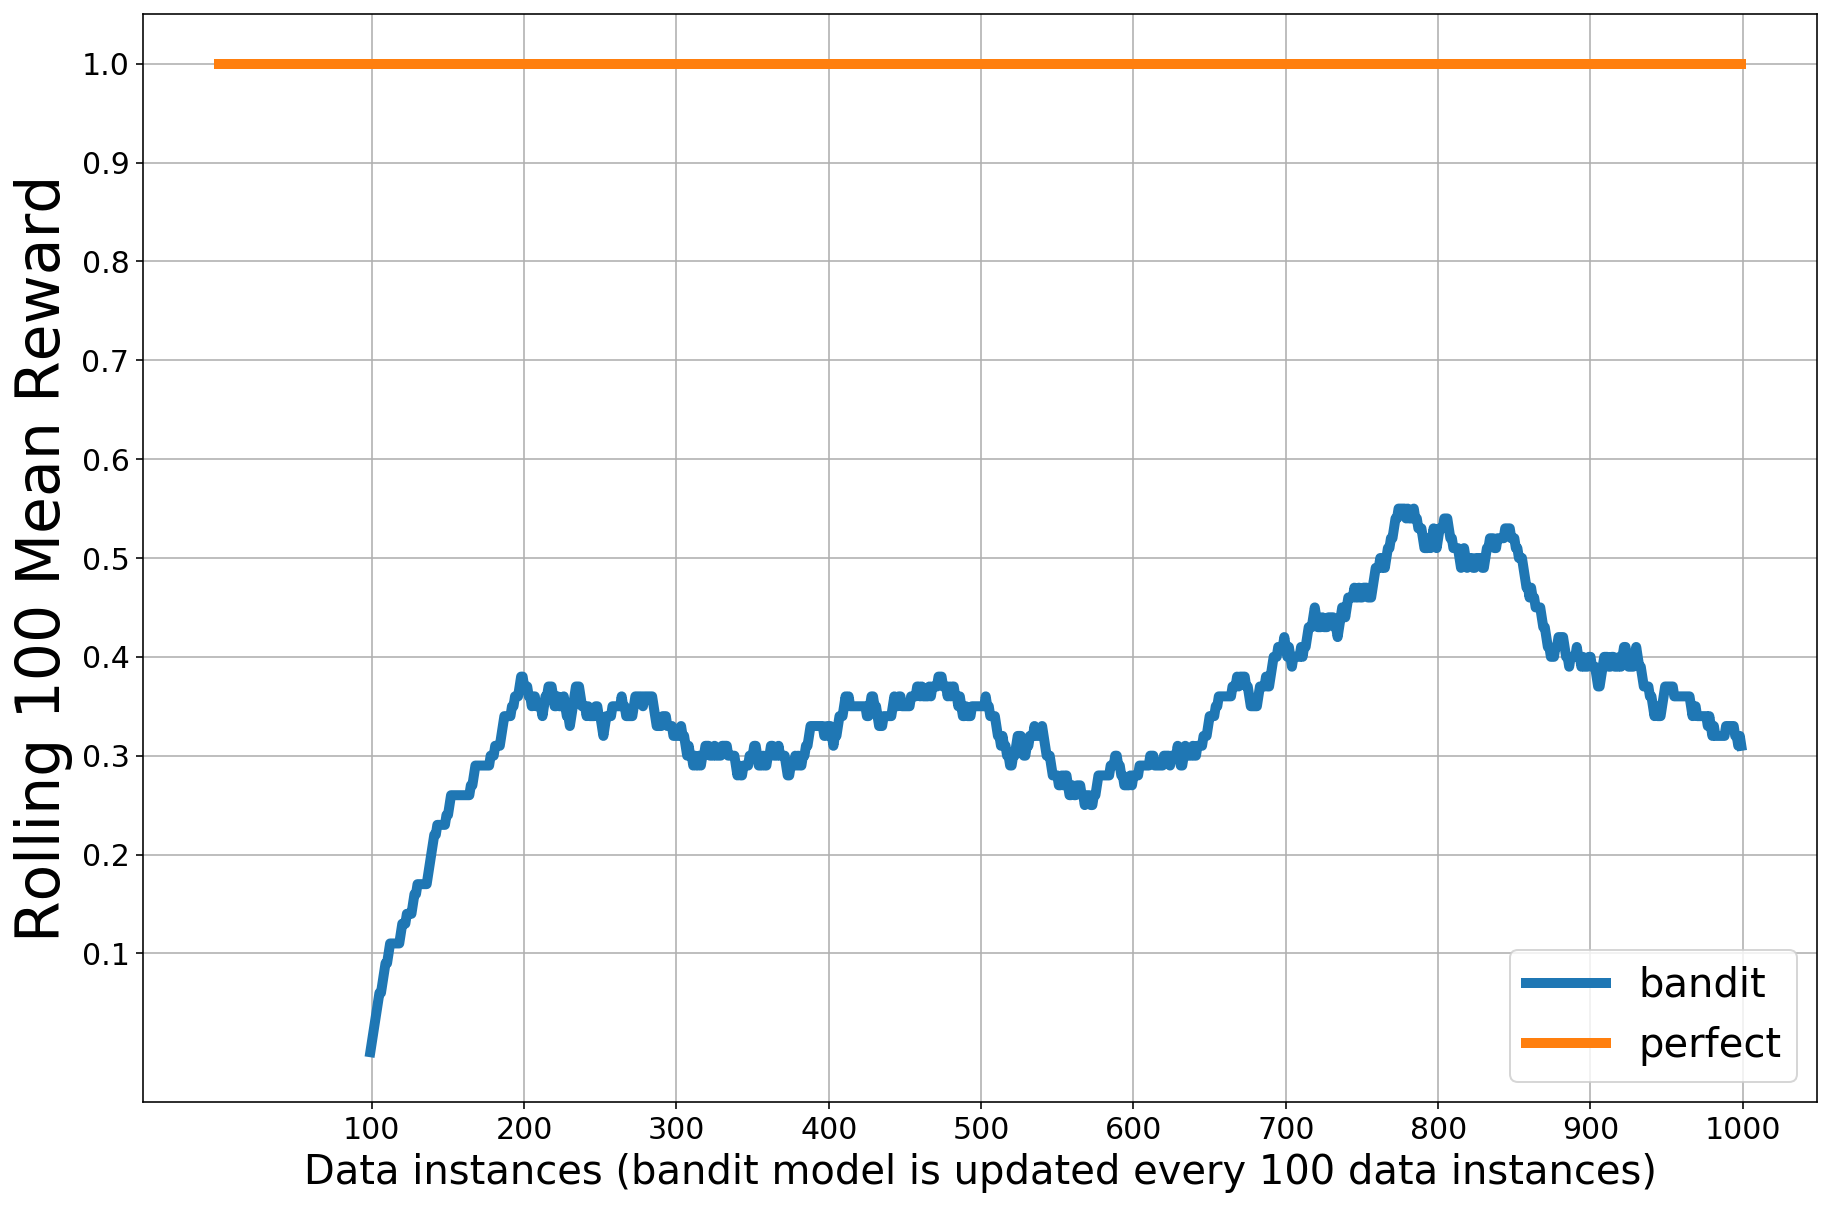

In [53]:
rolling_window = 100

rcParams['figure.figsize'] = 15, 10
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

rewards_df = pd.DataFrame(rewards_list, columns=['bandit']).rolling(rolling_window).mean()
rewards_df['perfect'] = sum(client_app.optimal_rewards) / len(client_app.optimal_rewards)

rewards_df.plot(y=['bandit', 'perfect'], 
                linewidth=lwd)
plt.legend(loc=4, prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=15)
plt.yticks([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
plt.xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

plt.xlabel('Data instances (bandit model is updated every %s data instances)' % retrain_batch_size, size=20)
plt.ylabel('Rolling {} Mean Reward'.format(rolling_window), size=30)
plt.grid()
plt.show()

# Check the Invocation Metrics for the BERT Models

In [54]:
from IPython.core.display import display, HTML
    
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search={}">Model 1 SageMaker REST Endpoint</a></b>'.format(region, model_1_endpoint_name)))


In [55]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search={}">Model 2 SageMaker REST Endpoint</a></b>'.format(region, model_2_endpoint_name)))


# Analyze the Reward Data Across All Models

In [56]:
rewards_df.tail(10)

,bandit,perfect
990,0.33,1.0
991,0.33,1.0
992,0.33,1.0
993,0.33,1.0
994,0.33,1.0
995,0.32,1.0
996,0.32,1.0
997,0.31,1.0
998,0.32,1.0
999,0.31,1.0


In [57]:
rewards_df.bandit.mean()

0.3506215316315201

# Clean Up

We have three DynamoDB tables from the bandits application above (e.g. `experiment_id='bandits-...'`). To better maintain them, we should remove the related records if the experiment has finished. 

Only execute the clean up cells below when you've finished the current experiment and want to deprecate everything associated with it. 

_The CloudWatch metrics will be removed during this cleanup step._

In [58]:
print('Cleaning up experiment_id {}'.format(bandit_experiment_manager.experiment_id))
try:
    bandit_experiment_manager.clean_resource(experiment_id=bandit_experiment_manager.experiment_id)
    bandit_experiment_manager.clean_table_records(experiment_id=bandit_experiment_manager.experiment_id)
except:
    print('Ignore any errors.  Errors are OK.')

INFO:orchestrator:Deleting hosting endpoint 'bandits-1598134018'...


Cleaning up experiment_id bandits-1598134018


Gracefully stopping... (press Ctrl+C again to force)
